In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ======================================================
# Cell 0: Environment Setup (no MALLET version)
# ======================================================

!pip install -U numpy==1.26.4 scipy==1.11.4 gensim==4.3.2 \
pandas==2.2.2 nltk==3.8.1 textblob==0.17.1 wordcloud==1.9.3 \
scikit-learn==1.5.2 matplotlib==3.9.2 seaborn==0.13.2 tqdm==4.66.5 \
pymupdf==1.24.9 pdfplumber==0.11.4

# ------------------------------------------------------
# NLTK + TextBlob setup
# ------------------------------------------------------
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from textblob import download_corpora
download_corpora.download_all()  # first time only

print("\n✅ Environment setup complete (no MALLET needed).")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 68.2 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pypdfium2-4.30.0-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (48 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 105.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 32.0 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 55.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 22.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 18.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 97.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 82.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 76.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 66.7 MB/s  0:00:00
 


✅ Environment setup complete (no MALLET needed).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-d

In [ ]:
# ======================================================
# Cell 1: Read PDF Pages
# ======================================================
import pdfplumber

pdf_path = "/content/drive/MyDrive/tcs-annual-report-2024-2025.pdf"  # change to your file path

pages = []
with pdfplumber.open(pdf_path) as pdf:
    for i, page in enumerate(pdf.pages):
        text = page.extract_text() or ""
        pages.append(text)

print(f"✅ Total pages read: {len(pages)}")
print("Sample text:\n", pages[0][:400])


✅ Total pages read: 336
Sample text:
 Integrated
Annual
Report
2024-25
Integrated Annual Report
2024-25


In [ ]:
# ======================================================
# Cell 2: Save PDF text into DataFrame
# ======================================================
import pandas as pd

df_pages = pd.DataFrame({
    "page_no": list(range(1, len(pages)+1)),
    "text": pages
})

# Drop empty pages
df_pages["text_length"] = df_pages["text"].str.len()
df_pages = df_pages[df_pages["text_length"] > 20].reset_index(drop=True)

print(df_pages.shape)
df_pages.head(3)


(334, 3)


,page_no,text,text_length
0,1,Integrated\nAnnual\nReport\n2024-25\nIntegrate...,65
1,2,Our Founder\nJamsetji Nusserwanji Tata\n03 Mar...,195
2,3,Remembering Mr. Tata\nPadma Vibhushan\nRatan N...,988


In [ ]:
# ======================================================
# Cell 3: Clean text (lowercase, remove punctuations, stopwords, etc.)
# ======================================================
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|\S+@\S+", " ", text)  # remove links/emails
    text = re.sub(r"[^a-z\s]", " ", text)                # remove non-letters
    text = re.sub(r"\s+", " ", text).strip()
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df_pages["clean_text"] = df_pages["text"].apply(clean_text)
df_pages[["page_no","clean_text"]].head(3)


,page_no,clean_text
0,1,integrated annual report integrated annual report
1,2,founder jamsetji nusserwanji tata march may fr...
2,3,remembering mr tata padma vibhushan ratan n ta...


In [ ]:
# ======================================================
# Cell 4: Sentence Tokenization + Sentiment
# ======================================================
from textblob import TextBlob
import nltk
nltk.download('punkt')

sent_rows = []
for _, row in df_pages.iterrows():
    page_no = row["page_no"]
    text = row["text"] or ""
    sentences = nltk.sent_tokenize(text)
    for sent in sentences:
        tb = TextBlob(sent)
        sent_rows.append((page_no, sent, tb.sentiment.polarity, tb.sentiment.subjectivity))

df_sents = pd.DataFrame(sent_rows, columns=["page_no","sentence","polarity","subjectivity"])
print("✅ Sentences extracted:", len(df_sents))
df_sents.head(10)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✅ Sentences extracted: 4913


,page_no,sentence,polarity,subjectivity
0,1,Integrated\nAnnual\nReport\n2024-25\nIntegrate...,0.000000,0.000000
1,2,Our Founder\nJamsetji Nusserwanji Tata\n03 Mar...,0.300000,0.550000
2,3,Remembering Mr. Tata\nPadma Vibhushan\nRatan N...,0.441667,1.000000
3,3,"From education to healthcare, his initiatives\...",0.066667,0.433333
4,3,generations to come.,0.000000,0.000000
5,3,Reinforcing all of this work\nwas Mr. Tata's g...,0.300000,0.466667
6,3,chairperson.,0.000000,0.000000
7,3,He inspired by example.,0.000000,0.000000
8,3,"With an\nunwavering commitment to excellence, ...",0.116667,0.300000
9,3,he so passionately championed.,-0.050000,0.850000


In [ ]:
# ======================================================
# Cell 5: Word Tokenization
# ======================================================
import nltk
nltk.download('punkt')

def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [t.lower() for t in tokens if t.isalpha()]
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return tokens

df_pages["tokens"] = df_pages["clean_text"].apply(tokenize_text)
df_pages[["page_no","tokens"]].head(3)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,page_no,tokens
0,1,"[integrated, annual, report, integrated, annua..."
1,2,"[founder, jamsetji, nusserwanji, tata, march, ..."
2,3,"[remembering, mr, tata, padma, vibhushan, rata..."


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['page_no'].plot(kind='hist', bins=20, title='page_no')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='index', y='page_no', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['page_no']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'page_no'}, axis=1)
              .sort_values('page_no', ascending=True))
  xs = counted['page_no']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('page_no', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('page_no')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['page_no'].plot(kind='line', figsize=(8, 4), title='page_no')
plt.gca().spines[['top', 'right']].set_visible(False)

Top 20 frequent words:
 [('company', 1308), ('financial', 1018), ('year', 848), ('tc', 762), ('report', 649), ('march', 649), ('statement', 579), ('asset', 537), ('service', 514), ('crore', 508), ('business', 450), ('value', 450), ('annual', 438), ('e', 410), ('director', 397), ('integrated', 395), ('tax', 383), ('fy', 353), ('share', 352), ('limited', 350)]


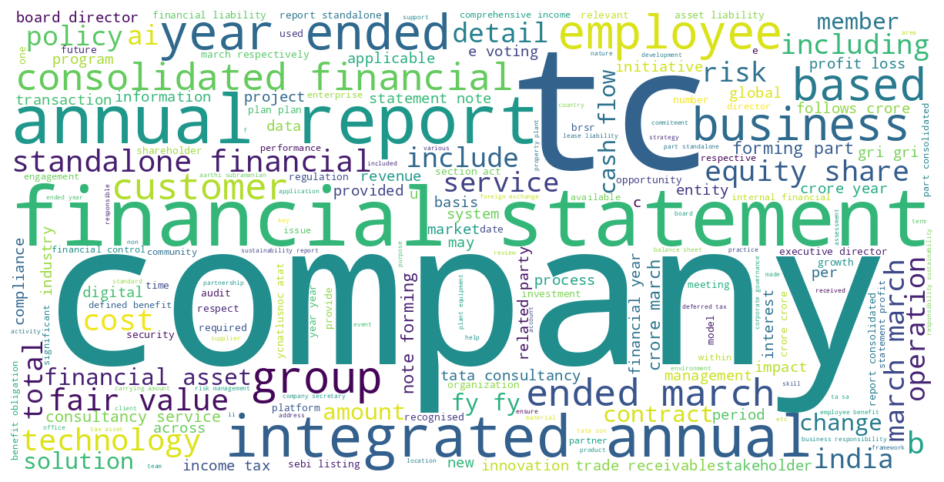

In [ ]:
# ======================================================
# Cell 6: Frequent Words + WordCloud
# ======================================================
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_tokens = [t for tokens in df_pages["tokens"] for t in tokens]
freq = Counter(all_tokens)

print("Top 20 frequent words:\n", freq.most_common(20))

wc = WordCloud(width=1200, height=600, background_color="white").generate(" ".join(all_tokens))
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


In [ ]:
# ======================================================
# Cell 7: Create TF-IDF & Document-Term Matrix
# ======================================================
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

documents = df_pages["clean_text"].tolist()

cv = CountVectorizer(max_df=0.9, min_df=2)
dtm = cv.fit_transform(documents)
print("DTM shape:", dtm.shape)

tfidf_vect = TfidfVectorizer(max_df=0.9, min_df=2)
tfidf = tfidf_vect.fit_transform(documents)
print("TF-IDF shape:", tfidf.shape)


DTM shape: (334, 4534)
TF-IDF shape: (334, 4534)


In [ ]:
# ======================================================
# Cell 8: Topic Modeling (Pure Python LDA)
# ======================================================
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

tokenized_docs = df_pages["tokens"].tolist()

dictionary = Dictionary(tokenized_docs)
dictionary.filter_extremes(no_below=3, no_above=0.9)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

num_topics = 10
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Show topics
for i, topic in lda_model.print_topics(num_topics=num_topics, num_words=10):
    print(f"\nTopic #{i}: {topic}")

# Evaluate coherence
coherence_model = CoherenceModel(model=lda_model, texts=tokenized_docs,
                                 dictionary=dictionary, coherence='c_v')
print("\n✅ Coherence Score:", coherence_model.get_coherence())



Topic #0: 0.026*"tc" + 0.011*"business" + 0.010*"ai" + 0.010*"service" + 0.010*"technology" + 0.008*"customer" + 0.008*"data" + 0.007*"digital" + 0.006*"solution" + 0.006*"innovation"

Topic #1: 0.019*"financial" + 0.018*"asset" + 0.018*"crore" + 0.017*"march" + 0.017*"year" + 0.016*"company" + 0.013*"statement" + 0.013*"value" + 0.012*"loss" + 0.012*"contract"

Topic #2: 0.034*"company" + 0.025*"director" + 0.021*"board" + 0.012*"regulation" + 0.011*"committee" + 0.009*"executive" + 0.009*"year" + 0.008*"act" + 0.008*"policy" + 0.007*"meeting"

Topic #3: 0.024*"limited" + 0.024*"tata" + 0.024*"plan" + 0.022*"benefit" + 0.019*"service" + 0.019*"march" + 0.015*"year" + 0.013*"obligation" + 0.013*"crore" + 0.012*"employee"

Topic #4: 0.029*"fy" + 0.018*"tc" + 0.015*"waste" + 0.010*"energy" + 0.009*"total" + 0.008*"scope" + 0.007*"student" + 0.007*"e" + 0.007*"company" + 0.007*"transaction"

Topic #5: 0.043*"financial" + 0.039*"company" + 0.032*"statement" + 0.023*"audit" + 0.017*"contro

In [ ]:
!pip install pyLDAvis

  Using cached pyLDAvis-3.4.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached funcy-2.0-py2.py3-none-any.whl.metadata (5.9 kB)
Using cached pyLDAvis-3.4.1-py3-none-any.whl (2.6 MB)
Using cached funcy-2.0-py2.py3-none-any.whl (30 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pyLDAvis]


In [ ]:
# ======================================================
# Optional: Interactive Topic Visualization (pyLDAvis)
# ======================================================
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.202287 -0.072335       1        1  21.284010
1     -0.166053 -0.092913       2        1  16.748821
2      0.104184  0.048395       3        1  13.519035
7      0.127953 -0.056295       4        1   8.853607
8     -0.183168 -0.043607       5        1   8.177117
5     -0.046769 -0.006045       6        1   7.576586
4      0.177406 -0.050469       7        1   7.511573
3     -0.066798 -0.117725       8        1   7.124559
6      0.025415  0.312181       9        1   6.216881
9     -0.174457  0.078813      10        1   2.987810, topic_info=            Term         Freq        Total Category  logprob  loglift
1563         tax   350.000000   350.000000  Default  30.0000  30.0000
71     financial  1000.000000  1000.000000  Default  29.0000  29.0000
427        asset   522.000000   522.000000  Default  28.0000  28.0000
157    statement   569.000000   569.000000  Default  27.0000  27.0000
2012       lease   234.000000   234.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
71     financial    23.472022  1000.205533  Topic10  -4.6745  -0.2415
157    statement    20.654473   569.839064  Topic10  -4.8024   0.1932
2156  recognised    15.598285   151.456872  Topic10  -5.0832   1.2375
7          march    16.323323   629.922974  Topic10  -5.0377  -0.1424
101      company    14.280340  1260.177507  Topic10  -5.1715  -0.9695

[712 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
348       2  0.085719   aarthi
348       3  0.822904   aarthi
348       5  0.085719   aarthi
1865      9  0.897202     able
2745      4  0.904404    abled
...     ...       ...      ...
3224     10  0.974185  yraunaj
3179      9  0.142344  yrtnuoc
3179     10  0.854062  yrtnuoc
1723      7  0.911379       zb
1290      7  0.834113      zwl

[2138 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 8, 9, 6, 5, 4, 7, 10])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
